In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


embedding = Embeddings(100, 100)

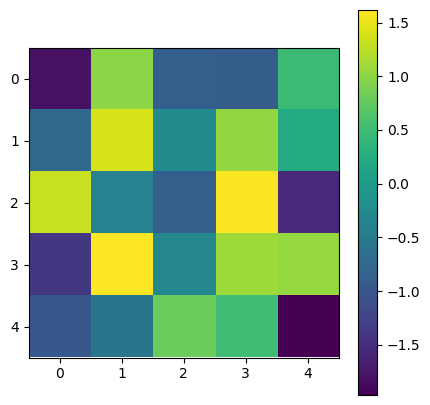

In [5]:
input = torch.randn(5, 5)
plt.figure(figsize=(5, 5))
plt.imshow(input)
plt.colorbar()
plt.show()

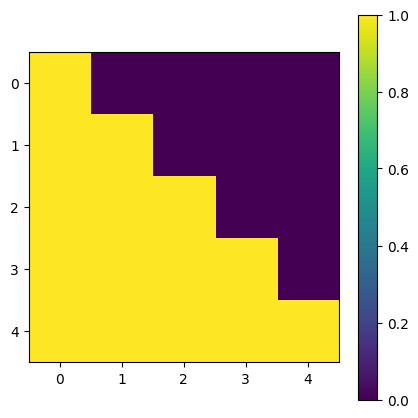

In [8]:
def subsequent_mask(sz):
    attn_shape = (1, sz, sz)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(1 - subsequent_mask)


seq_mask = subsequent_mask(5)
plt.figure(figsize=(5, 5))
plt.imshow(seq_mask[0])
plt.colorbar()
plt.show()

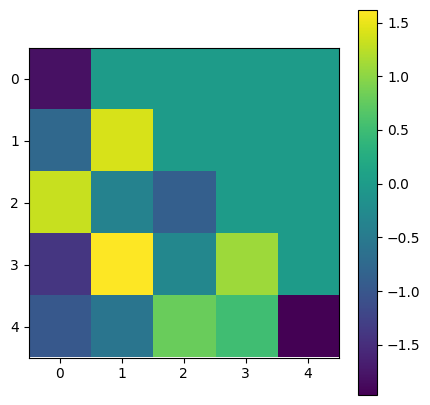

In [11]:
masked_input = input.masked_fill(seq_mask[0] == 0, 1e-9)
plt.figure(figsize=(5, 5))
plt.imshow(masked_input)
plt.colorbar()
plt.show()